<a href="https://colab.research.google.com/github/Utpal-Mishra/Python-Commerce-Prediction/blob/main/MHHECommercePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INSTALL LIBRARIES

In [ ]:
!pip install catboost
!pip install lightgbm

#IMPORT

###LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
from matplotlib import cm as cm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import time
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dense, Activation, Flatten
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

###GOOGLE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


###TRAINING DATA

In [ ]:
import pandas as pd

path = '/content/drive/My Drive/Hackathon/Machine Hack Hackathons/E-Commerce Prediction/Data/Train.csv'
train = pd.read_csv(path)
print(train.shape)
train.head()

(2452, 8)


,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,02-03-2017,291
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,07-01-2015,897
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,01-12-2019,792
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12-12-2014,837
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12-12-2013,470


###TESTING DATA

In [ ]:
import pandas as pd

path = '/content/drive/My Drive/Hackathon/Machine Hack Hackathons/E-Commerce Prediction/Data/Test.csv'
test = pd.read_csv(path)
print(test.shape)
test.head()

(1051, 7)


,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date
0,P-11284,B-2984,computers,network components,routers,4.3,2018-12-01
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,2012-12-20
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,2014-12-01
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,2019-12-01
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,2017-12-01


#DATA PRE-PROCESSING

###TRAINING DATA PRE-PRECESSING

In [ ]:
train.describe()

,Item_Rating,Selling_Price
count,2452.000000,2452.000000
mean,3.078467,2494.375612
std,1.187137,7115.256516
min,1.000000,33.000000
25%,2.000000,371.000000
50%,3.100000,596.000000
75%,4.100000,1195.250000
max,5.000000,116289.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        2452 non-null   object 
 1   Product_Brand  2452 non-null   object 
 2   Item_Category  2452 non-null   object 
 3   Subcategory_1  2452 non-null   object 
 4   Subcategory_2  2452 non-null   object 
 5   Item_Rating    2452 non-null   float64
 6   Date           2452 non-null   object 
 7   Selling_Price  2452 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 153.4+ KB


DATETIME CONVERSION

In [ ]:
import datetime as dt
train['Date'] = pd.to_datetime(train['Date'])
train['Date'] = train['Date'].map(dt.datetime.toordinal)
train.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,736363,291
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,735780,897
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,737071,792
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,735579,837
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,735214,470


CATEGORICAL ENCODING

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
train['Product_Brand'] = LE.fit(train['Product_Brand']).transform(train['Product_Brand'])
train['Item_Category'] = LE.fit(train['Item_Category']).transform(train['Item_Category'])
train['Subcategory_1'] = LE.fit(train['Subcategory_1']).transform(train['Subcategory_1'])
train['Subcategory_2'] = LE.fit(train['Subcategory_2']).transform(train['Subcategory_2'])
train.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,862,7,10,137,4.3,736363,291
1,P-2453,670,10,127,329,3.1,735780,897
2,P-6802,280,29,112,101,3.5,737071,792
3,P-4452,670,8,37,134,4.0,735579,837
4,P-8454,670,10,80,296,4.3,735214,470


In [ ]:
import numpy as np
import statsmodels.api as sm

X_opt = np.append(arr = np.ones((train.drop(['Selling_Price', "Product", "Date", "Item_Rating"], axis = 1).shape[0], 1)), 
                  values = train.drop(['Selling_Price', "Product", "Date", "Item_Rating"], axis = 1).values, axis = 1)
regressor_OLS = sm.OLS(train['Selling_Price'].values, X_opt).fit()
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     56.24
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           1.91e-45
Time:                        23:01:39   Log-Likelihood:                -25120.
No. Observations:                2452   AIC:                         5.025e+04
Df Residuals:                    2447   BIC:                         5.028e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        428.8112    433.508      0.989      0.3

CHECK FOR NULL VALUES

In [ ]:
train.isnull().sum()

Product          0
Product_Brand    0
Item_Category    0
Subcategory_1    0
Subcategory_2    0
Item_Rating      0
Date             0
Selling_Price    0
dtype: int64

###TESTING DATA PRE-PRECESSING




In [ ]:
test.describe()

,Item_Rating
count,1051.000000
mean,3.074025
std,1.210880
min,1.000000
25%,2.000000
50%,3.100000
75%,4.100000
max,5.000000


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Product        1051 non-null   object 
 1   Product_Brand  1051 non-null   object 
 2   Item_Category  1051 non-null   object 
 3   Subcategory_1  1051 non-null   object 
 4   Subcategory_2  1051 non-null   object 
 5   Item_Rating    1051 non-null   float64
 6   Date           1051 non-null   object 
dtypes: float64(1), object(6)
memory usage: 57.6+ KB


DATETIME CONVERSION

In [ ]:
import datetime as dt
test['Date'] = pd.to_datetime(test['Date'])
test['Date'] = test['Date'].map(dt.datetime.toordinal)
test.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date
0,P-11284,B-2984,computers,network components,routers,4.3,737029
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,734857
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,735568
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,737394
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,736664


CATEGORICAL ENCODING

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
test['Product_Brand'] = LE.fit(test['Product_Brand']).transform(test['Product_Brand'])
test['Item_Category'] = LE.fit(test['Item_Category']).transform(test['Item_Category'])
test['Subcategory_1'] = LE.fit(test['Subcategory_1']).transform(test['Subcategory_1'])
test['Subcategory_2'] = LE.fit(test['Subcategory_2']).transform(test['Subcategory_2'])
test.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date
0,P-11284,324,13,62,136,4.3,737029
1,P-6580,129,27,8,28,3.0,734857
2,P-5843,338,12,90,191,1.5,735568
3,P-5334,83,27,61,114,3.9,737394
4,P-5586,338,12,90,191,1.4,736664


CHECK FOR NULL VALUES

In [ ]:
test.isnull().sum()

Product          0
Product_Brand    0
Item_Category    0
Subcategory_1    0
Subcategory_2    0
Item_Rating      0
Date             0
dtype: int64

#DATA SPLITTING

In [ ]:
from sklearn.model_selection import train_test_split

X = train.drop(['Selling_Price', "Product", "Date", "Item_Rating"], axis = 1).values
Y = train['Selling_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
print("X_train.shape:", X_train.shape, "| X_test.shape:", X_test.shape, "| Y_train.shape:", Y_train.shape, "| Y_test.shape:", Y_test.shape)

X_train.shape: (1961, 4) | X_test.shape: (491, 4) | Y_train.shape: (1961,) | Y_test.shape: (491,)


In [ ]:
import statsmodels.api as sm
X_Opt = np.append(arr = np.ones((X_train.shape[0], 1)), values = X_train, axis = 1)
regressor_OLS = sm.OLS(Y_train, X_Opt).fit()
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:          Selling_Price   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     44.09
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           1.77e-35
Time:                        23:01:54   Log-Likelihood:                -20133.
No. Observations:                1961   AIC:                         4.028e+04
Df Residuals:                    1956   BIC:                         4.030e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        351.8515    500.810      0.703      0.4

TESTING DATA

In [ ]:
XTest = test
XTest.shape

(1051, 7)

In [ ]:
import statsmodels.api as sm
X_Opt = np.append(arr = np.ones((X_test.shape[0], 1)), values = X_test, axis = 1)
regressor_OLS = sm.OLS(Y_test, X_Opt).fit()
print(regressor_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:          Selling_Price   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     12.41
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           1.28e-09
Time:                        23:01:58   Log-Likelihood:                -4980.7
No. Observations:                 491   AIC:                             9971.
Df Residuals:                     486   BIC:                             9992.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        647.6271    850.081      0.762      0.4

#MODELLING

In [ ]:
REGRESSOR = ['LINEAR REGRESSION','RIDGE REGRESSION','RIDGE COMPLEXITY','LASSO REGRESSION','LARS LASSO REGRESSION', 'DECISION TREE','DECISION TREE BAGGING', 'EXTRA TREE BAGGING', 
             'GRADIENT DESCEBT REGRESSOR', 'RANDOM FOREST', 'XGBOOST', 'ADABOOST', 'CATBOOST']
TRAIN_ACCURACY = []
VARIANCE_SCORE = []
ABSOLUTE_ERROR = []
MEAN_SQUARED_ERROR = []
MEDIAN_ABSOLUTE_ERROR = []
R_SQUARE_SCORE = []

###BUILDING REGRESSION MODELS

###ENSEMBLE MODELLING USING CROSS VALIDATION

In [ ]:
models_list = []
models_list.append(('KNN', KNeighborsRegressor()))
models_list.append(('SVM', SVR(C=1.7, kernel='rbf'))) 
models_list.append(('NB', GaussianNB()))
models_list.append(('DT', DecisionTreeRegressor()))
models_list.append(('BAG', BaggingRegressor(DecisionTreeRegressor())))
models_list.append(('ET', ExtraTreesRegressor()))
models_list.append(('RF', RandomForestRegressor()))
models_list.append(('GB', GradientBoostingRegressor()))
models_list.append(('XGB', XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75)))
models_list.append(('ADB', AdaBoostRegressor()))

ACCURACY = {}
EVALUATION = {}

In [ ]:
num_folds = 10
results = []
names = []

for name, model in models_list:
    kfold = KFold(n_splits=num_folds)
    start = time.time()
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

KNN: 0.440019 (0.160233) (run time: 0.041597)
SVM: -0.072529 (0.011129) (run time: 2.218886)
NB: 0.010712 (0.006230) (run time: 0.795302)
DT: 0.404579 (0.767745) (run time: 0.056801)
BAG: 0.583289 (0.233903) (run time: 0.405742)
ET: 0.550738 (0.508022) (run time: 2.163496)
RF: 0.669695 (0.164793) (run time: 3.807231)
GB: 0.636827 (0.270172) (run time: 1.293602)
[23:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:22:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[

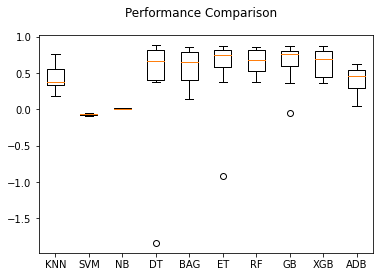

In [ ]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

PIPELINING

In [ ]:
# Standardize the dataset
pipelines = []

pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledSVC', Pipeline([('Scaler', StandardScaler()),('SVM', SVR(C=1.7, kernel='rbf'))])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('DT', DecisionTreeRegressor())])))
pipelines.append(('ScaledBAG', Pipeline([('Scaler', StandardScaler()),('BAG', BaggingRegressor(DecisionTreeRegressor()))])))
pipelines.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
pipelines.append(('ScaledGB', Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingRegressor())])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()),('GB', XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75))])))
pipelines.append(('ScaledADB', Pipeline([('Scaler', StandardScaler()),('ADB', AdaBoostRegressor())])))

results = []
names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kfold = KFold(n_splits=num_folds, random_state=123)
    for name, model in pipelines:
        start = time.time()
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
        end = time.time()
        results.append(cv_results)
        names.append(name)
        print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

ScaledKNN: 0.605685 (0.162137) (run time: 0.568569)
ScaledSVC: -0.072056 (0.010847) (run time: 2.248723)
ScaledNB: 0.010712 (0.006230) (run time: 0.765924)
ScaledDT: 0.402510 (0.769937) (run time: 0.071451)
ScaledBAG: 0.666866 (0.146567) (run time: 0.440667)
ScaledET: 0.519003 (0.587884) (run time: 2.229689)
ScaledRF: 0.659244 (0.166262) (run time: 4.042296)
ScaledGB: 0.682896 (0.168209) (run time: 1.290850)
[23:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear i

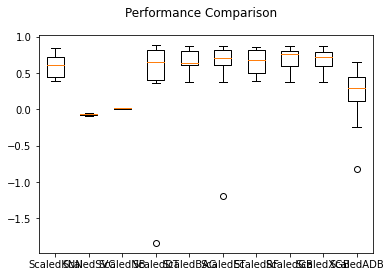

In [ ]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###ENSEMBLE MODELLING USING CROSS VALIDATION FOR CATBOOSTREGRESSION

In [ ]:
models_list = []
models_list.append(('CATB', CatBoostRegressor()))

ACCURACY = {}
EVALUATION = {}

In [ ]:
num_folds = 10
results = []
names = []

for name, model in models_list:
    kfold = KFold(n_splits=num_folds)
    start = time.time()
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold)
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

Streaming output truncated to the last 5000 lines.
6:	learn: 6250.6168441	total: 9.92ms	remaining: 1.41s
7:	learn: 6131.0880181	total: 11.3ms	remaining: 1.4s
8:	learn: 6028.1615885	total: 12.6ms	remaining: 1.39s
9:	learn: 5930.4427366	total: 13.9ms	remaining: 1.37s
10:	learn: 5812.5118349	total: 15.2ms	remaining: 1.37s
11:	learn: 5702.5425563	total: 16.5ms	remaining: 1.36s
12:	learn: 5614.0335497	total: 17.8ms	remaining: 1.35s
13:	learn: 5533.3456180	total: 19.2ms	remaining: 1.35s
14:	learn: 5458.4319062	total: 20.5ms	remaining: 1.34s
15:	learn: 5380.2431795	total: 21.8ms	remaining: 1.34s
16:	learn: 5295.1099944	total: 23.1ms	remaining: 1.33s
17:	learn: 5211.3266513	total: 24.4ms	remaining: 1.33s
18:	learn: 5136.9928630	total: 25.7ms	remaining: 1.32s
19:	learn: 5068.8702562	total: 26.9ms	remaining: 1.32s
20:	learn: 5007.7003151	total: 28.2ms	remaining: 1.32s
21:	learn: 4951.8676276	total: 29.5ms	remaining: 1.31s
22:	learn: 4896.0120070	total: 30.8ms	remaining: 1.31s
23:	learn: 4844.629

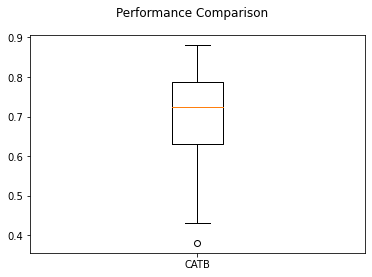

In [ ]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

PIPELINING

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledCATB', Pipeline([('Scaler', StandardScaler()),('CATB', CatBoostRegressor())])))

results = []
names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kfold = KFold(n_splits=num_folds, random_state=123)
    for name, model in pipelines:
        start = time.time()
        cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring="neg_mean_squared_error")
        end = time.time()
        results.append(cv_results)
        names.append(name)
        print( "%s: %f (%f) (run time: %f)" % (name, cv_results.mean(), cv_results.std(), end-start))

Streaming output truncated to the last 5000 lines.
6:	learn: 6250.6168441	total: 9.88ms	remaining: 1.4s
7:	learn: 6131.0880181	total: 11.2ms	remaining: 1.39s
8:	learn: 6028.1615885	total: 12.5ms	remaining: 1.38s
9:	learn: 5930.4427366	total: 13.8ms	remaining: 1.36s
10:	learn: 5812.5118349	total: 15.1ms	remaining: 1.36s
11:	learn: 5702.5425563	total: 16.4ms	remaining: 1.35s
12:	learn: 5614.0335497	total: 17.7ms	remaining: 1.34s
13:	learn: 5533.3456180	total: 19ms	remaining: 1.34s
14:	learn: 5458.4319062	total: 20.3ms	remaining: 1.33s
15:	learn: 5380.2431795	total: 21.6ms	remaining: 1.33s
16:	learn: 5295.1099944	total: 22.9ms	remaining: 1.32s
17:	learn: 5211.3266513	total: 24.2ms	remaining: 1.32s
18:	learn: 5136.9928630	total: 25.5ms	remaining: 1.32s
19:	learn: 5068.8702562	total: 26.8ms	remaining: 1.31s
20:	learn: 5007.7003151	total: 28.1ms	remaining: 1.31s
21:	learn: 4951.8676276	total: 29.4ms	remaining: 1.31s
22:	learn: 4896.0120070	total: 30.7ms	remaining: 1.3s
23:	learn: 4844.629494

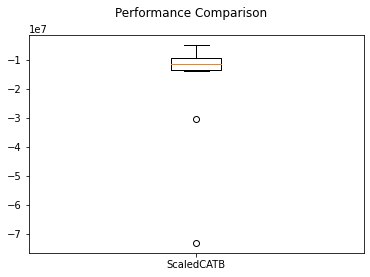

In [ ]:
fig = plt.figure()
fig.suptitle('Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###LINEAR REGRESSION

In [ ]:
from sklearn import linear_model, metrics

LR = linear_model.LinearRegression(normalize=True)

LR.fit(X_train, Y_train)
LR_pred = LR.predict(X_test)
print ('Coefficients: ', LR.coef_)
print ('Intercept: ', LR.intercept_)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", LR.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,LR_pred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test,LR_pred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test,LR_pred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test,LR_pred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,LR_pred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,LR_pred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test,LR_pred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test,LR_pred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test,LR_pred))

Coefficients:  [-3.66274184 54.97005534 -2.06930855 15.99624377]
Intercept:  351.8514520015251

REGRESSION REPORT:

TRAINING ACCURACY:	 0.08270419721779565
VARIANCE SCORE:		 0.09109820053881368
ABSOLUTE ERROR:		 3241.5168894848525
MEAN SQUARED ERROR:	 37960428.10633521
MEDIAN ABSOLUTE ERROR:   2185.0372251338235
R-SQUARE SCORE:  	 0.09079791229317025


In [ ]:
TRAIN_ACCURACY.append(LR.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test,LR_pred))
#MAX_ERROR.append(metrics.max_error(Y_test,LR_pred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test,LR_pred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test,LR_pred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test,LR_pred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test,LR_pred))

###RIDGE REGRESSION

In [ ]:
from sklearn import linear_model, metrics

RR = linear_model.Ridge(alpha=.5)
RR.fit(X_train, Y_train)
RR_pred = RR.predict(X_test)
print ('Coefficients: ', RR.coef_)
print ('Intercept: ', RR.intercept_)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", RR.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,RR_pred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test,RR_pred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test,RR_pred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test,RR_pred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,RR_pred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,RR_pred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test,RR_pred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test,RR_pred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test,RR_pred))

Coefficients:  [-3.66274173 54.97000747 -2.06930395 15.99624251]
Intercept:  351.8523958270275

REGRESSION REPORT:

TRAINING ACCURACY:	 0.08270419721778266
VARIANCE SCORE:		 0.09109820831135174
ABSOLUTE ERROR:		 3241.516678330894
MEAN SQUARED ERROR:	 37960427.78482473
MEDIAN ABSOLUTE ERROR:   2185.0363184899643
R-SQUARE SCORE:  	 0.09079791999376818


In [ ]:
TRAIN_ACCURACY.append(RR.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test,RR_pred))
#MAX_ERROR.append(metrics.max_error(Y_test,RR_pred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test,RR_pred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test,RR_pred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test,RR_pred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test,RR_pred))

###RIDGE COMPLEXITY

In [ ]:
from sklearn import linear_model, metrics

RC = linear_model.RidgeCV()
RC.fit(X_train, Y_train)
RC_pred = RC.predict(X_test)
print ('Coefficients: ', RC.coef_)
print ('Intercept: ', RC.intercept_)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", RC.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,RC_pred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test,RC_pred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test,RC_pred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test,RC_pred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,RC_pred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,RC_pred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test,RC_pred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test,RC_pred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test,RC_pred))

Coefficients:  [-3.66273963 54.96909804 -2.06921651 15.99621856]
Intercept:  351.87034856830815

REGRESSION REPORT:

TRAINING ACCURACY:	 0.0827041972126571
VARIANCE SCORE:		 0.09109835602940086
ABSOLUTE ERROR:		 3241.5126673360164
MEAN SQUARED ERROR:	 37960421.67424694
MEDIAN ABSOLUTE ERROR:   2185.019103936299
R-SQUARE SCORE:  	 0.09079806635012844


In [ ]:
TRAIN_ACCURACY.append(RC.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test,RC_pred))
#MAX_ERROR.append(metrics.max_error(Y_test,RC_pred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test,RC_pred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test,RC_pred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test,RC_pred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test,RC_pred))

###LASSO REGRESSION

In [ ]:
from sklearn import linear_model, metrics

LassoR = linear_model.Lasso(alpha=0.1)
LassoR.fit(X_train, Y_train)
LassoR_pred = LassoR.predict(X_test)
print ('Coefficients: ', LassoR.coef_)
print ('Intercept: ', LassoR.intercept_)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", LassoR.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,LassoR_pred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, LassoR_pred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, LassoR_pred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, LassoR_pred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test, LassoR_pred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test, LassoR_pred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, LassoR_pred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, LassoR_pred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test,LassoR_pred))

Coefficients:  [-3.66274075 54.96968162 -2.06920295 15.99621631]
Intercept:  351.85635903940965

REGRESSION REPORT:

TRAINING ACCURACY:	 0.08270419721682953
VARIANCE SCORE:		 0.09109823748693058
ABSOLUTE ERROR:		 3241.515182720931
MEAN SQUARED ERROR:	 37960426.59023913
MEDIAN ABSOLUTE ERROR:   2185.0269290296387
R-SQUARE SCORE:  	 0.0907979486056617


In [ ]:
TRAIN_ACCURACY.append(LassoR.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test,LassoR_pred))
#MAX_ERROR.append(metrics.max_error(Y_test, LassoR_pred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, LassoR_pred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, LassoR_pred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, LassoR_pred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, LassoR_pred))

###LARS LASSO REGRESSION

In [ ]:
from sklearn import linear_model, metrics

LARSLassoR = linear_model.LassoLars(alpha=0.1)
LARSLassoR.fit(X_train, Y_train)
LARSLassoR_pred = LARSLassoR.predict(X_test)
print ('Coefficients: ', LARSLassoR.coef_)
print ('Intercept: ', LARSLassoR.intercept_)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", LARSLassoR.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,LARSLassoR_pred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, LARSLassoR_pred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, LARSLassoR_pred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, LARSLassoR_pred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test, LARSLassoR_pred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test, LARSLassoR_pred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, LARSLassoR_pred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, LARSLassoR_pred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test,LARSLassoR_pred))

Coefficients:  [-3.64655685 54.6200715  -1.87619795 15.91954769]
Intercept:  350.2698761358397

REGRESSION REPORT:

TRAINING ACCURACY:	 0.08270192906877283
VARIANCE SCORE:		 0.09107979988022219
ABSOLUTE ERROR:		 3238.6055129603305
MEAN SQUARED ERROR:	 37961285.66974615
MEDIAN ABSOLUTE ERROR:   2177.6269569078418
R-SQUARE SCORE:  	 0.09077737252366636


In [ ]:
TRAIN_ACCURACY.append(LARSLassoR.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test,LARSLassoR_pred))
#MAX_ERROR.append(metrics.max_error(Y_test, LARSLassoR_pred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, LARSLassoR_pred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, LARSLassoR_pred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, LARSLassoR_pred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, LARSLassoR_pred))

###DECISION TREE

In [ ]:
DT = DecisionTreeRegressor()
DT.fit(X_train,Y_train)
DTPred = DT.predict(X_test)
DT.score(X_test, Y_test)
DT.fit(X_test, Y_test)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", DT.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,DTPred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, DTPred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, DTPred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, DTPred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,DTPred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,DTPred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, DTPred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, DTPred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test, DTPred))


REGRESSION REPORT:

TRAINING ACCURACY:	 0.39808703864794304
VARIANCE SCORE:		 0.8951669786222328
ABSOLUTE ERROR:		 739.6949669394475
MEAN SQUARED ERROR:	 4383286.51739785
MEDIAN ABSOLUTE ERROR:   188.02380952380952
R-SQUARE SCORE:  	 0.8950145335170702


In [ ]:
TRAIN_ACCURACY.append(DT.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test,DTPred))
#MAX_ERROR.append(metrics.max_error(Y_test, DTPred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, DTPred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, DTPred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test,DTPred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, DTPred))

###DECISON TREE BAGGING

In [ ]:
Bagging = BaggingRegressor(DecisionTreeRegressor())
Bagging.fit(X_train, Y_train)
BPred = Bagging.predict(X_test)
Bagging.score(X_test, Y_test)
Bagging.fit(X_test, Y_test)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", Bagging.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,BPred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, BPred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, BPred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, BPred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,BPred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,BPred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, BPred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, BPred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test, BPred))


REGRESSION REPORT:

TRAINING ACCURACY:	 0.6106310261295576
VARIANCE SCORE:		 0.8686244280423712
ABSOLUTE ERROR:		 831.5174233814801
MEAN SQUARED ERROR:	 5485290.075629957
MEDIAN ABSOLUTE ERROR:   202.0709343932217
R-SQUARE SCORE:  	 0.8686201015839441


In [ ]:
TRAIN_ACCURACY.append(Bagging.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test, BPred))
#MAX_ERROR.append(metrics.max_error(Y_test, BPred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, BPred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, BPred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, BPred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, BPred))

###EXTRA TREE CLASSFIER

In [ ]:
ET = ExtraTreesRegressor()
ET.fit(X_train, Y_train)
ET.score(X_train, Y_train)
ETPred = ET.predict(X_test)
ET.score(X_test, Y_test)
ET.fit(X_test, Y_test)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", ET.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,ETPred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, ETPred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, ETPred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, ETPred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,ETPred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,ETPred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, ETPred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, ETPred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test, ETPred))


REGRESSION REPORT:

TRAINING ACCURACY:	 0.635318475450815
VARIANCE SCORE:		 0.8988634864970337
ABSOLUTE ERROR:		 776.2966940624851
MEAN SQUARED ERROR:	 4222674.486987883
MEDIAN ABSOLUTE ERROR:   196.87388888888972
R-SQUARE SCORE:  	 0.898861402497328


In [ ]:
TRAIN_ACCURACY.append(ET.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test, ETPred))
#MAX_ERROR.append(metrics.max_error(Y_test, ETPred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, ETPred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, ETPred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, ETPred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, ETPred))

###GRADIANT BOOSTING Regressor

In [ ]:
GB = GradientBoostingRegressor()
GB.fit(X_train, Y_train)
GBPred = GB.predict(X_test)
GB.score(X_test, Y_test)
print(GB.score(X_test, Y_test))
GB.fit(X_test, Y_test)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", GB.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,GBPred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, GBPred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, GBPred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, GBPred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,GBPred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,GBPred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, GBPred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, GBPred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test, GBPred))

0.8508207531905647

REGRESSION REPORT:

TRAINING ACCURACY:	 0.5862951551448634
VARIANCE SCORE:		 0.8508232791709972
ABSOLUTE ERROR:		 1028.0790809082453
MEAN SQUARED ERROR:	 6228437.164887813
MEDIAN ABSOLUTE ERROR:   358.3972894169042
R-SQUARE SCORE:  	 0.8508207531905646


In [ ]:
TRAIN_ACCURACY.append(GB.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test, GBPred))
#MAX_ERROR.append(metrics.max_error(Y_test, GBPred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, GBPred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, GBPred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, GBPred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, GBPred))

###RANDOM FOREST

In [ ]:
RF = RandomForestRegressor()
RF.fit(X_train,Y_train)
RFPred = RF.predict(X_test)
print(RF.score(X_test, Y_test))
RF.fit(X_test, Y_test)

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", RF.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,RF_pred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, RF_pred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, RF_pred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, RF_pred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test, RF_pred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test, RF_pred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, RF_pred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, RF_pred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test, RF_pred))

0.8698583113788066

REGRESSION REPORT:

TRAINING ACCURACY:	 0.6256316408221774
VARIANCE SCORE:		 -0.9036534983782654
ABSOLUTE ERROR:		 3578.6598436682216
MEAN SQUARED ERROR:	 79500311.44594014
MEDIAN ABSOLUTE ERROR:   615.7552177700348
R-SQUARE SCORE:  	 -0.9041368273696797


In [ ]:
TRAIN_ACCURACY.append(RF.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test,RF_pred))
#MAX_ERROR.append(metrics.max_error(Y_test, RF_pred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, RF_pred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, RF_pred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, RF_pred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, RF_pred))

###XGBOOST

In [ ]:
XGB = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75)
XGB.fit(X_train, Y_train, verbose=False)
XGBPred = XGB.predict(X_test)
XGB.fit(X_test, Y_test, verbose=False)
print(XGB.score(X_test, Y_test))

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", XGB.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,XGBPred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, XGBPred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, XGBPred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, XGBPred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,XGBPred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,XGBPred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, XGBPred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, XGBPred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test, XGBPred))

[00:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9373145797378252

REGRESSION REPORT:

TRAINING ACCURACY:	 0.6204035201934237
VARIANCE SCORE:		 0.8498032350120588
ABSOLUTE ERROR:		 1056.181267468361
MEAN SQUARED ERROR:	 6270973.007604413
MEDIAN ABSOLUTE ERROR:   412.41583251953125
R-SQUARE SCORE:  	 0.8498019639163243


In [ ]:
TRAIN_ACCURACY.append(XGB.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test, XGBPred))
#MAX_ERROR.append(metrics.max_error(Y_test, XGBPred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, XGBPred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, XGBPred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, XGBPred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, XGBPred))

###ADABOOST

In [ ]:
ADAB = AdaBoostRegressor()
ADAB.fit(X_train, Y_train)
ADABPred = ADAB.predict(X_test)
ADAB.fit(X_test, Y_test)
print(ADAB.score(X_test, Y_test))

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", ADAB.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test, ADABPred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, ADBPred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, ADABPred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, ADABPred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,ADABPred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,ADABPred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, ADABPred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, ADABPred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test, ADABPred))

0.8765706363572585

REGRESSION REPORT:

TRAINING ACCURACY:	 0.5824217335621164
VARIANCE SCORE:		 0.6453124209194235
ABSOLUTE ERROR:		 2430.171556178536
MEAN SQUARED ERROR:	 16162264.221377024
MEDIAN ABSOLUTE ERROR:   1097.1538461538462
R-SQUARE SCORE:  	 0.6128925540306805


In [ ]:
TRAIN_ACCURACY.append(ADAB.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test, ADABPred))
#MAX_ERROR.append(metrics.max_error(Y_test, ADABPred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, ADABPred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, ADABPred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, ADABPred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, ADABPred))

###CATBOOST

In [ ]:
CDAB = CatBoostRegressor()
CDAB.fit(X_train, Y_train)
CDABPred = ADAB.predict(X_test)
CDAB.fit(X_test, Y_test)
print(CDAB.score(X_test, Y_test))

print("\nREGRESSION REPORT:\n")
print("TRAINING ACCURACY:\t", CADB.score(X_train, Y_train))
print("VARIANCE SCORE:\t\t", metrics.explained_variance_score(Y_test,CDABPred))
#print("MAX ERROR:\t\t", metrics.max_error(Y_test, CDABPred))
print("ABSOLUTE ERROR:\t\t", metrics.mean_absolute_error(Y_test, CDABPred))
print("MEAN SQUARED ERROR:\t", metrics.mean_squared_error(Y_test, CDABPred))
#print("MEAN SQUARED LOG ERROR: ", metrics.mean_squared_log_error(Y_test,CDABPred))
print("MEDIAN ABSOLUTE ERROR:  ", metrics.median_absolute_error(Y_test,CDABPred))
print("R-SQUARE SCORE:  \t", metrics.r2_score(Y_test, CDABPred))
#print("MEAN POISSON DEVIANCE: ", metrics.mean_poisson_deviance(Y_test, CDABPred))
#print("MEAN GAMMA DEVIANCE: ", metrics.mean_gamma_deviance(Y_test, CDABPred))

Learning rate set to 0.044001
0:	learn: 7063.6766912	total: 1.67ms	remaining: 1.67s
1:	learn: 6876.9027797	total: 3.24ms	remaining: 1.61s
2:	learn: 6699.0530848	total: 4.64ms	remaining: 1.54s
3:	learn: 6557.9349193	total: 6.04ms	remaining: 1.5s
4:	learn: 6419.6301415	total: 7.43ms	remaining: 1.48s
5:	learn: 6270.8248198	total: 8.78ms	remaining: 1.45s
6:	learn: 6131.3090317	total: 10.2ms	remaining: 1.44s
7:	learn: 6013.5767716	total: 11.5ms	remaining: 1.43s
8:	learn: 5894.9216014	total: 12.9ms	remaining: 1.42s
9:	learn: 5793.7253475	total: 14.2ms	remaining: 1.41s
10:	learn: 5676.8210915	total: 15.6ms	remaining: 1.4s
11:	learn: 5578.8830936	total: 17ms	remaining: 1.4s
12:	learn: 5486.9329592	total: 18.4ms	remaining: 1.39s
13:	learn: 5402.6924180	total: 19.7ms	remaining: 1.38s
14:	learn: 5324.7562497	total: 21.1ms	remaining: 1.38s
15:	learn: 5250.8211762	total: 22.4ms	remaining: 1.38s
16:	learn: 5187.8116617	total: 23.8ms	remaining: 1.37s
17:	learn: 5107.7953544	total: 25.1ms	remaining: 1

NameError: ignored

In [ ]:
TRAIN_ACCURACY.append(CDAB.score(X_train, Y_train))
VARIANCE_SCORE.append(metrics.explained_variance_score(Y_test, CDABPred))
#MAX_ERROR.append(metrics.max_error(Y_test, CDABPred))
ABSOLUTE_ERROR.append(metrics.mean_absolute_error(Y_test, CDABPred))
MEAN_SQUARED_ERROR.append(metrics.mean_squared_error(Y_test, CDABPred))
MEDIAN_ABSOLUTE_ERROR.append(metrics.median_absolute_error(Y_test, CDABPred))
R_SQUARE_SCORE.append(metrics.r2_score(Y_test, CDABPred))

###PERFORMANCE EVALUATION

In [ ]:
PERFORMANCE = pd.DataFrame({
'REGRESSOR' : REGRESSOR,
'ACCURACY %' : TRAIN_ACCURACY,
'VARIANCE SCORE' : VARIANCE_SCORE,
'ABSOLUTE ERROR' : ABSOLUTE_ERROR,
'MEAN SQUARED ERROR' : MEAN_SQUARED_ERROR,
'MEDIAN ABSOLUTE ERROR' : MEDIAN_ABSOLUTE_ERROR,
'R-SQUARE SCORE' : R_SQUARE_SCORE })

In [ ]:
PERFORMANCE

,REGRESSOR,ACCURACY %,VARIANCE SCORE,ABSOLUTE ERROR,MEAN SQUARED ERROR,MEDIAN ABSOLUTE ERROR,R-SQUARE SCORE
0,LINEAR REGRESSION,0.082704,0.091098,3241.516889,3.796043e+07,2185.037225,0.090798
1,RIDGE REGRESSION,0.082704,0.091098,3241.516678,3.796043e+07,2185.036318,0.090798
2,RIDGE COMPLEXITY,0.082704,0.091098,3241.512667,3.796042e+07,2185.019104,0.090798
3,LASSO REGRESSION,0.082704,0.091098,3241.515183,3.796043e+07,2185.026929,0.090798
4,LARS LASSO REGRESSION,0.082702,0.091080,3238.605513,3.796129e+07,2177.626957,0.090777
5,DECISION TREE,0.397514,0.896786,733.410659,4.316834e+06,188.023810,0.896606
6,DECISION TREE BAGGING,0.624776,0.883704,800.879184,4.855647e+06,210.100000,0.883701
7,EXTRA TREE BAGGING,0.624776,0.897215,778.162960,4.291428e+06,197.500000,0.897215
8,GRADIENT DESCEBT REGRESSOR,0.624776,0.850923,1027.496585,6.224278e+06,358.397289,0.850920
9,RANDOM FOREST,0.621835,-0.903653,3578.659844,7.950031e+07,615.755218,-0.904137


In [ ]:
REGRESSOR[PERFORMANCE.index[PERFORMANCE['MEAN SQUARED ERROR'] == PERFORMANCE['MEAN SQUARED ERROR'].min()].tolist()[0]]